In [46]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.14.0
TensorFlow Decision Forests v1.8.0


In [14]:
data=pd.read_csv("/content/train.csv")
data.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [15]:
plot_df = data.Transported.value_counts()
plot_df

True     4378
False    4315
Name: Transported, dtype: int64

<Axes: xlabel='Transported', ylabel='Count'>

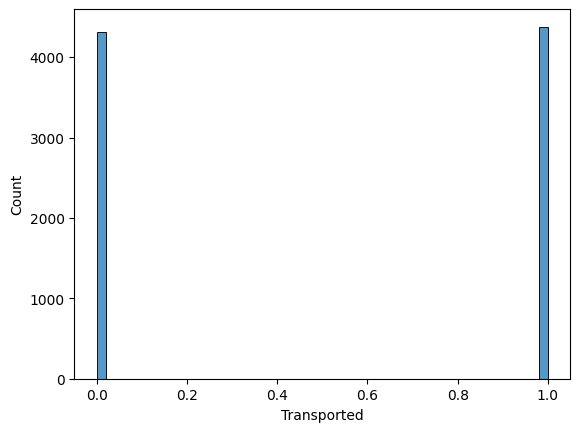

In [16]:
data['Transported']=data['Transported'].replace({True : 1, False :  0})
data['Transported']

data.Transported.value_counts()

sns.histplot(data['Transported'],bins=50)

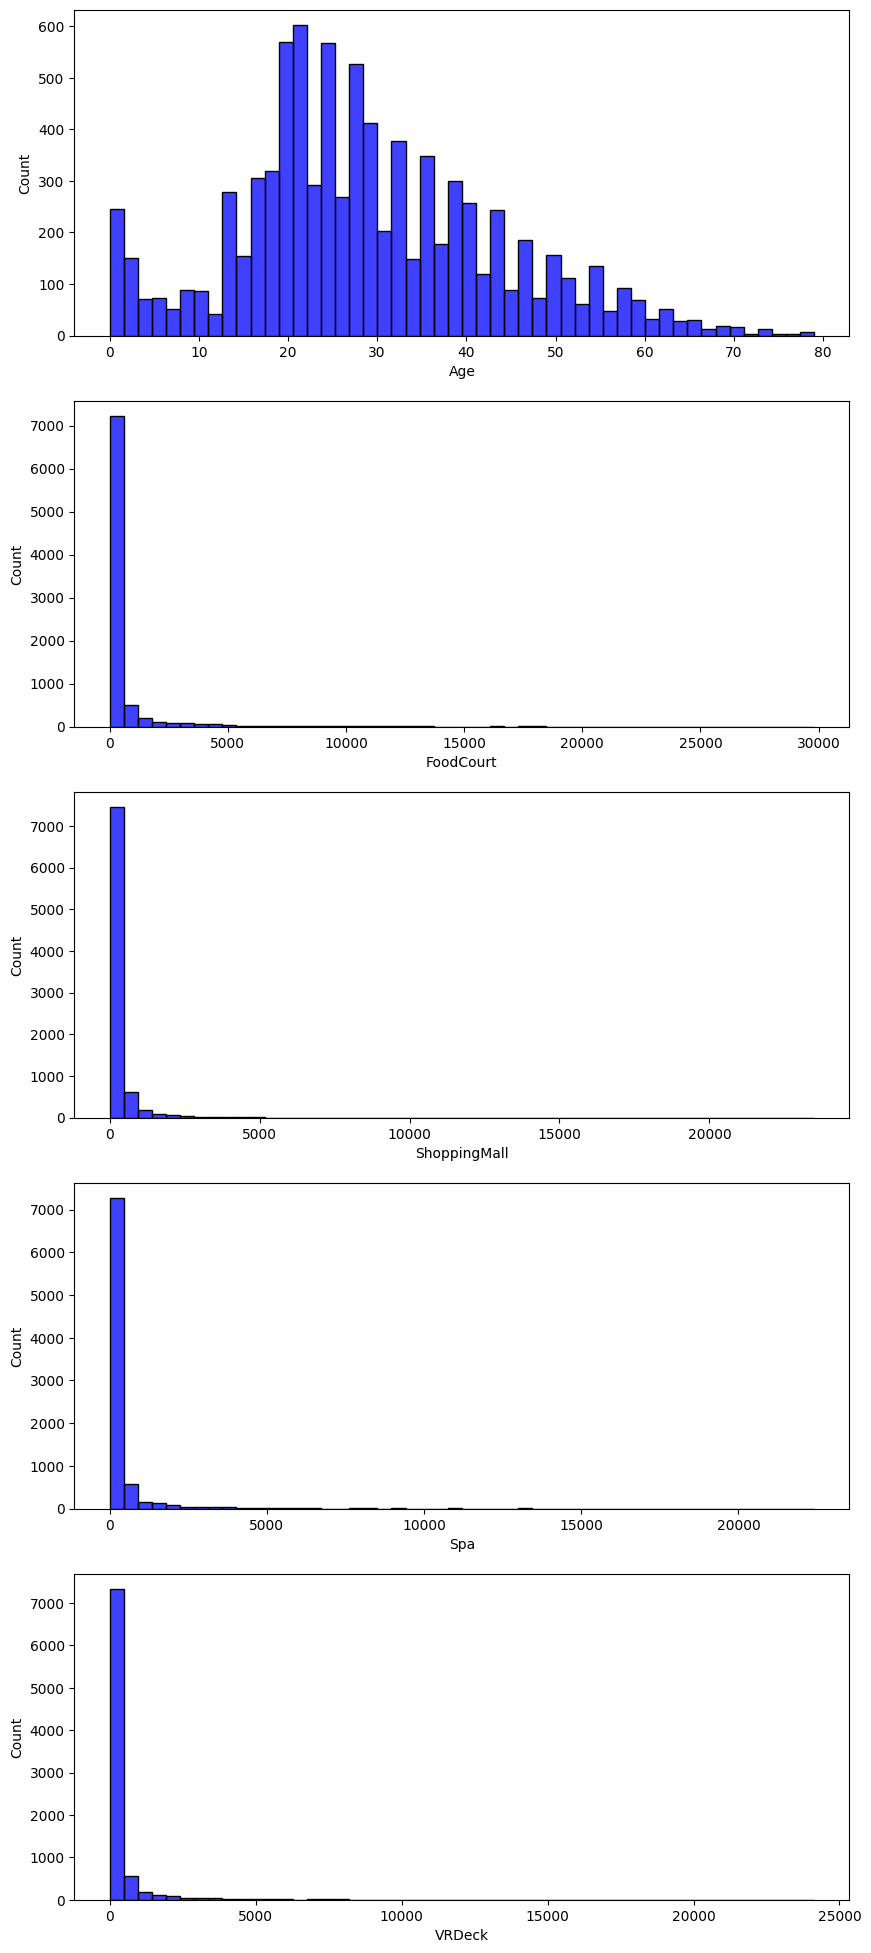

In [17]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(data['Age'], color='b', bins=50, ax=ax[0]);
sns.histplot(data['FoodCourt'], color='b', bins=50, ax=ax[1]);
sns.histplot(data['ShoppingMall'], color='b', bins=50, ax=ax[2]);
sns.histplot(data['Spa'], color='b', bins=50, ax=ax[3]);
sns.histplot(data['VRDeck'], color='b', bins=50, ax=ax[4]);

In [18]:
#on supprime les colonnes passengers id et Name se sont pas nécessaire pour le training

data= data.drop(['PassengerId', 'Name'], axis=1)
data.head(5)



,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1


In [19]:
valeurs_manquantes = data.isna().sum()
valeurs_manquantes

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

In [20]:
for colonne in data.columns:
    # Vérifier si la colonne est numérique
    if data[colonne].dtype in ['float64', 'int64']:
        # Calculer la moyenne de la colonne
        moyenne = data[colonne].mean()
        # Remplacer les valeurs manquantes par la moyenne
        data[colonne].fillna(moyenne, inplace=True)

data


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,0
8689,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,0
8690,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,1
8691,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,0


In [21]:
valeurs_manquantes=data.isna().sum()
valeurs_manquantes

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age               0
VIP             203
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64

In [22]:
# on va créer de nouveaux features pour la colonne cabin => 3 nouvelles colonnes

data[['C1','C2','C3']]=data['Cabin'].str.split('/',expand=True)

data.head(5)


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,C1,C2,C3
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0,B,0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1,F,0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0,A,0,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0,A,0,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1,F,1,S


In [23]:
data['C2'] = pd.to_numeric(data['C2'], errors='coerce')
moyenne_C2=data['C2'].mean()

data['C2'].fillna(moyenne_C2, inplace=True)


data.head(5)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,C1,C2,C3
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0,B,0.0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1,F,0.0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0,A,0.0,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0,A,0.0,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1,F,1.0,S


In [24]:
data['VIP']=data['VIP'].replace({True : 1,False : 0})
data.head(5)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,C1,C2,C3
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,B,0.0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1,F,0.0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0,A,0.0,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0,A,0.0,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1,F,1.0,S


In [25]:
df=pd.DataFrame(data)
df.head(5)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,C1,C2,C3
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,B,0.0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1,F,0.0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0,A,0.0,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0,A,0.0,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1,F,1.0,S


In [26]:
df['CryoSleep']=df['CryoSleep'].replace({True : 1 , False : 0})
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,C1,C2,C3
0,Europa,0.0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,B,0.0,P
1,Earth,0.0,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1,F,0.0,S
2,Europa,0.0,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0,A,0.0,S
3,Europa,0.0,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0,A,0.0,S
4,Earth,0.0,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1,F,1.0,S


In [27]:
homePlanet=data['HomePlanet'].copy()
homePlanet

0       Europa
1        Earth
2       Europa
3       Europa
4        Earth
         ...  
8688    Europa
8689     Earth
8690     Earth
8691    Europa
8692    Europa
Name: HomePlanet, Length: 8693, dtype: object

In [28]:
df=df.drop('HomePlanet',axis=1)
df=df.drop('Cabin', axis=1)
df=df.drop('Destination',axis=1)

df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,C1,C2,C3
0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,B,0.0,P
1,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1,F,0.0,S
2,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0,A,0.0,S
3,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0,A,0.0,S
4,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1,F,1.0,S
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,0,A,98.0,P
8689,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0,G,1499.0,S
8690,0.0,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,1,G,1500.0,S
8691,0.0,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,0,E,608.0,S


In [29]:
df.head(5)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,C1,C2,C3
0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,B,0.0,P
1,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1,F,0.0,S
2,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0,A,0.0,S
3,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0,A,0.0,S
4,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1,F,1.0,S


In [30]:
label_encoder_c1 = LabelEncoder()
label_encoder_c3 = LabelEncoder()


df['C1_encoded'] = label_encoder_c1.fit_transform(df['C1'])
df['C3_encoded'] = label_encoder_c3.fit_transform(df['C3'])

df.head(5)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,C1,C2,C3,C1_encoded,C3_encoded
0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,B,0.0,P,1,0
1,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1,F,0.0,S,5,1
2,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0,A,0.0,S,0,1
3,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0,A,0.0,S,0,1
4,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1,F,1.0,S,5,1


In [31]:
df=df.drop("C1",axis=1)
df=df.drop("C3",axis=1)


df.head(5)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,C2,C1_encoded,C3_encoded
0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1,0
1,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1,0.0,5,1
2,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0,0.0,0,1
3,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0,0.0,0,1
4,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1,1.0,5,1


In [32]:
valeurs_manquantes = df.isna().sum()
valeurs_manquantes

CryoSleep       217
Age               0
VIP             203
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
C2                0
C1_encoded        0
C3_encoded        0
dtype: int64

In [33]:
for colonne in df.columns:
    # Vérifier si la colonne est numérique
    if df[colonne].dtype in ['float64', 'int64']:
        # Calculer la moyenne de la colonne
        moyenne = df[colonne].mean()
        # Remplacer les valeurs manquantes par la moyenne
        df[colonne].fillna(moyenne, inplace=True)

df


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,C2,C1_encoded,C3_encoded
0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1,0
1,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1,0.0,5,1
2,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0,0.0,0,1
3,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0,0.0,0,1
4,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1,1.0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,0,98.0,0,0
8689,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1499.0,6,1
8690,0.0,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,1,1500.0,6,1
8691,0.0,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,0,608.0,4,1


In [34]:
valeurs_manquantes = df.isna().sum()
valeurs_manquantes

CryoSleep       0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
C2              0
C1_encoded      0
C3_encoded      0
dtype: int64

In [35]:
df['C2'] = pd.to_numeric(df['C2'], errors='coerce')
df.head(5)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,C2,C1_encoded,C3_encoded
0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1,0
1,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1,0.0,5,1
2,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0,0.0,0,1
3,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0,0.0,0,1
4,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1,1.0,5,1


In [48]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

6954 examples in training, 1739 examples in testing.


In [50]:
# Enregistrer les dataframes en fichiers CSV
train_ds_pd.to_csv('train_dataset.csv', index=False)
valid_ds_pd.to_csv('test_dataset.csv', index=False)


In [51]:
rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmptsjurcq6 as temporary training directory


In [52]:
rf = tfdf.keras.RandomForestModel()
rf.compile(metrics=["accuracy"])

Use /tmp/tmppj1aa_wh as temporary training directory


In [54]:

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label='Transported', task=tfdf.keras.Task.CLASSIFICATION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label='Transported', task=tfdf.keras.Task.CLASSIFICATION)


In [55]:
#training
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:06.720195. Found 6954 examples.
Training model...
Model trained in 0:00:08.256152
Compiling model...
Model compiled.


In [56]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

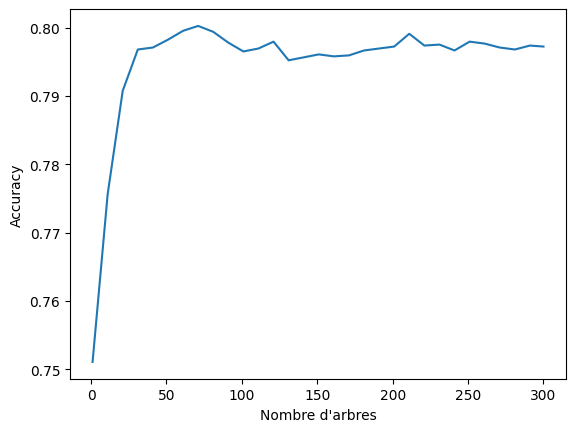

In [58]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Nombre d'arbres")
plt.ylabel("Accuracy")
plt.show()

In [59]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=6954, accuracy=0.7972389991371872, loss=0.4922859196402888, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

In [60]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

2/2 [==============================] - 1s 94ms/step - loss: 0.0000e+00 - accuracy: 0.8131
loss: 0.0000
accuracy: 0.8131


In [61]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_NODES
	 NUM_AS_ROOT
	 SUM_SCORE
	 INV_MEAN_MIN_DEPTH


In [62]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("CryoSleep" (1; #4), 160.0),
 ("RoomService" (1; #6), 56.0),
 ("Spa" (1; #8), 46.0),
 ("VRDeck" (1; #10), 31.0),
 ("ShoppingMall" (1; #7), 6.0),
 ("FoodCourt" (1; #5), 1.0)]

In [64]:
test_df = pd.read_csv('/content/test_dataset.csv')
test_df.head(5)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,C2,C1_encoded,C3_encoded
0,0.0,39.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0,0.0,1,0
1,0.0,16.0,0.0,303.0,70.0,151.000000,565.0,2.000000,1,1.0,5,1
2,1.0,28.0,0.0,0.0,0.0,0.000000,0.0,304.854791,1,0.0,6,1
3,1.0,34.0,0.0,0.0,0.0,173.729169,0.0,0.000000,1,1.0,1,0
4,0.0,27.0,0.0,1286.0,122.0,173.729169,0.0,0.000000,0,3.0,5,0


In [67]:
dd=pd.read_csv("/content/train.csv")
dd.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [71]:
# Load the test dataset
test_df = pd.read_csv('/content/test_dataset.csv')


# Replace NaN values with zero
test_df[['VIP', 'CryoSleep']] = test_df[['VIP', 'CryoSleep']].fillna(value=0)

# Creating New Features - Deck, Cabin_num and Side from the column Cabin and remove Cabin


# Convert boolean to 1's and 0's
test_df['VIP'] = test_df['VIP'].astype(int)
test_df['CryoSleep'] = test_df['CryoSleep'].astype(int)

# Convert pd dataframe to tf dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

# Get the predictions for testdata
predictions = rf.predict(test_ds)
n_predictions = (predictions > 0.5).astype(bool)
output = pd.DataFrame({
                       'Transported': n_predictions.squeeze()})

output.head()

2/2 [==============================] - 0s 87ms/step


,Transported
0,False
1,False
2,True
3,True
4,False


In [36]:
df.to_csv('data_readyto_train.csv', index=False)


In [37]:
# On applique le pca
# réduction de dim =2


df = pd.DataFrame(df)


pca = PCA(n_components=2)

principal_components = pca.fit_transform(df)


pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

pca_df


,PC1,PC2
0,-547.751676,-193.772761
1,-377.215210,170.707350
2,4586.162402,2549.157292
3,1594.835417,1478.613702
4,-330.875382,129.211192
...,...,...
8688,6165.571297,-1847.268374
8689,-651.005186,-255.422097
8690,-659.381674,-238.313508
8691,1384.933460,1779.725756


/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


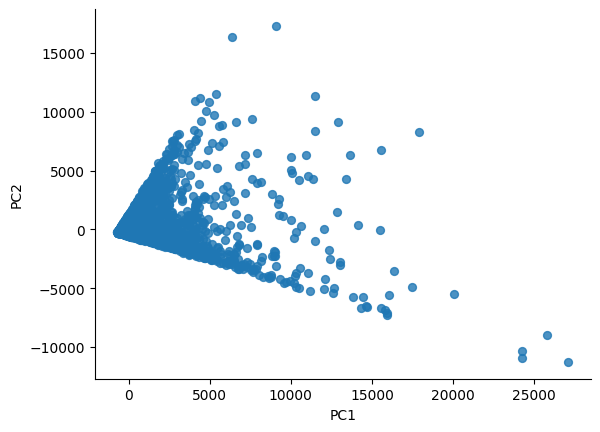

In [38]:
from matplotlib import pyplot as plt
pca_df.plot(kind='scatter', x='PC1', y='PC2', s=32, alpha=.8,cmap='coolwarm')
plt.gca().spines[['top', 'right',]].set_visible(False)

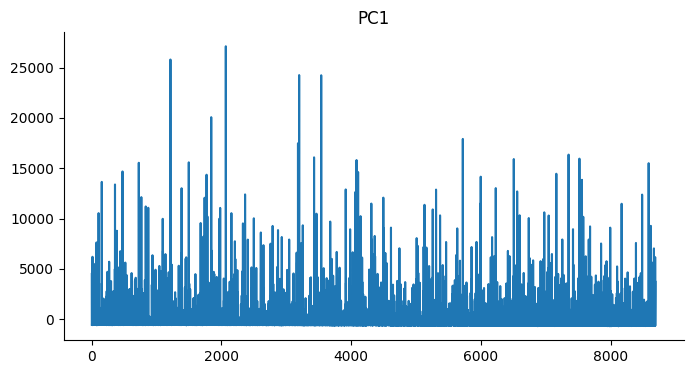

In [39]:
from matplotlib import pyplot as plt
pca_df['PC1'].plot(kind='line', figsize=(8, 4), title='PC1')
plt.gca().spines[['top', 'right']].set_visible(False)

In [40]:
#Models entrainement

tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [41]:
data_df=pd.read_csv("/content/data_readyto_train.csv")

data_df

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,C2,C1_encoded,C3_encoded
0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1,0
1,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,1,0.0,5,1
2,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,0,0.0,0,1
3,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,0,0.0,0,1
4,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,1,1.0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,0,98.0,0,0
8689,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1499.0,6,1
8690,0.0,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,1,1500.0,6,1
8691,0.0,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,0,608.0,4,1


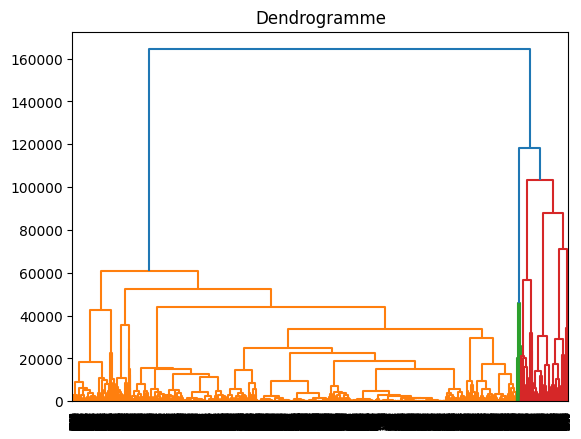

In [42]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

data = pd.read_csv('/content/data_readyto_train.csv')


model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(data)

linkage_matrix = linkage(data, 'ward')
dendrogram(linkage_matrix)
plt.title('Dendrogramme')
plt.show()


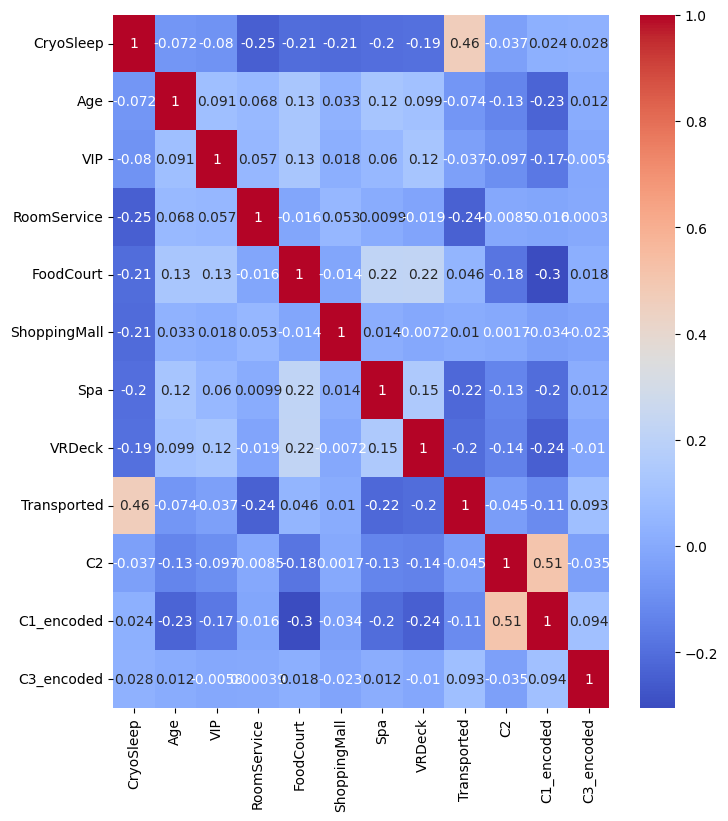

In [43]:
matrix_corr=data_df.corr()

plt.figure(figsize=(8,9))
sns.heatmap(matrix_corr,annot=True, cmap="coolwarm")
plt.show()

In [44]:
pairs = matrix_corr.unstack()


unique_pairs = pairs.loc[pairs.index.get_level_values(0) < pairs.index.get_level_values(1)]


sorted_pairs = unique_pairs.abs().sort_values(ascending=False)

sorted_pairs[:3]

C1_encoded  C2             0.506986
CryoSleep   Transported    0.462756
C1_encoded  FoodCourt      0.303867
dtype: float64

In [45]:


X = data_df[['C1_encoded', 'C2', 'Transported', 'CryoSleep', 'FoodCourt']]
y = data_df['Transported']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train)


y_pred = random_forest_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 1.0


In [72]:
import nbformat
from nbconvert import PDFExporter
from traitlets.config import Config

with open('Titanic_kaggle.ipynb') as f:
    nb = nbformat.read(f, as_version=4)

# Configurer l'exportateur PDF
c = Config()
c.PDFExporter.preprocessors = ['nbconvert.preprocessors.ExtractOutputPreprocessor']

exporter = PDFExporter(config=c)
exporter.template_file = 'article'  # Vous pouvez choisir différents styles de template

# Convertir en PDF
body, resources = exporter.from_notebook_node(nb)

# Enregistrer le fichier PDF
with open('titanic_kaggle.pdf', 'wb') as f:
    f.write(body)


FileNotFoundError: ignored